<a href="https://colab.research.google.com/github/NedKost/MS-AAI-500-Team-Project/blob/Anova-Branch/Collisions_timeslice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd

with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()
    for i in range(656688, 656694):  # Checking a few lines around the problematic row
        print(i, lines[i-1])  # Adjusting for 0-indexing


656688 04/25/2018,8:39,,,40.63529,-73.958206,"(40.63529, -73.958206)",OCEAN AVENUE                    ,,,1,0,0,0,0,0,1,0,Driver Inattention/Distraction,Unspecified,,,,3887903,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,,,

656689 05/08/2018,16:13,,,40.61384,-73.981445,"(40.61384, -73.981445)",65 STREET                       ,,,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,,,,3896211,Box Truck,Station Wagon/Sport Utility Vehicle,,,

656690 04/29/2018,14:45,BROOKLYN,11208,40.668613,-73.86857,"(40.668613, -73.86857)",,,2602      LINDEN BOULEVARD              ,0,0,0,0,0,0,0,0,Unspecified,,,,,3891070,Station Wagon/Sport Utility Vehicle,,,,

656691 05/14/2018,15:00,,,40.617573,-74.15293,"(40.617573, -74.15293)",,,5         DEPPE PLACE                   ,0,0,0,0,0,0,0,0,Following Too Closely,Following Too Closely,Unspecified,,,3900833,Sedan,Station Wagon/Sport Utility Vehicle,,,

656692 05/06/2018,11:30,BRONX,10458,40.856358,-73.88591,"(40.856358, -73.

In [47]:
df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv', skiprows=[656692])


<ipython-input-47-1227a6f6c89a>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv', skiprows=[656692])


In [48]:
with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()

# Excluding problematic line
cleaned_lines = [line for idx, line in enumerate(lines) if idx != 656691]

# Converting cleaned lines into a df
from io import StringIO
data = StringIO('\n'.join(cleaned_lines))
df = pd.read_csv(data)


<ipython-input-48-c343242cf94f>:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428448 entries, 0 to 1428447
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     1428448 non-null  object 
 1   CRASH TIME                     1428448 non-null  object 
 2   BOROUGH                        948298 non-null   object 
 3   ZIP CODE                       948065 non-null   object 
 4   LATITUDE                       1283748 non-null  float64
 5   LONGITUDE                      1283748 non-null  float64
 6   LOCATION                       1283748 non-null  object 
 7   ON STREET NAME                 1100964 non-null  object 
 8   CROSS STREET NAME              793545 non-null   object 
 9   OFF STREET NAME                292617 non-null   object 
 10  NUMBER OF PERSONS INJURED      1428430 non-null  float64
 11  NUMBER OF PERSONS KILLED       1428417 non-null  float64
 12  NUMBER OF PEDE

In [49]:
df['YEAR'] = df['CRASH DATE'].apply(lambda x: int(x.split('/')[2]))
df = df[df['YEAR'] > 2017]


In [50]:
causation_mapping_df = pd.read_csv('causation_factor_mapping_file.csv')

def map_causation(cause, mapping_df):
    """Return the category corresponding to a causation factor."""

    if pd.isna(cause):
        return 'Unknown'

    return mapping_df[mapping_df['Causation Factor'] == cause]['Category'].iloc[0]

# Apply the mapping function to the 'CONTRIBUTING FACTOR VEHICLE 1' column
df['CAUSE CATEGORY'] = df['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: map_causation(x, causation_mapping_df))


 Convert 'CRASH DATE' and 'CRASH TIME' to Datetime Format

In [51]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME']).dt.time


For easier analysis, extracting specific time-based features


In [53]:
# Extracting Month, Day, Day of the Week, and Hour
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['DAY_OF_WEEK'] = df['CRASH DATE'].dt.dayofweek  # Returns 0 for Monday and 6 for Sunday
df['HOUR'] = df['CRASH DATE'].dt.hour


Handling missing values (if any)

In [54]:
# Check for missing values in 'CRASH DATE' and 'CRASH TIME'
missing_dates = df['CRASH DATE'].isna().sum()
missing_times = df['CRASH TIME'].isna().sum()

print(f"Missing Dates: {missing_dates}")
print(f"Missing Times: {missing_times}")


Missing Dates: 0
Missing Times: 0


Outlier Detection

In [55]:
print("Earliest Crash Date:", df['CRASH DATE'].min())
print("Latest Crash Date:", df['CRASH DATE'].max())


Earliest Crash Date: 2018-01-01 00:00:00
Latest Crash Date: 2023-07-23 00:00:00


Depending on the geographic region, accidents may have some seasonality (e.g., more accidents during winter months due to snow). Adding a 'SEASON' column

In [56]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['SEASON'] = df['MONTH'].apply(get_season)


Time of day, as in, classify 'CRASH TIME' into periods of the day

In [70]:
from datetime import time

def get_time_period(t):
    if t < time(6, 0):
        return 'Night'
    elif t < time(12, 0):
        return 'Morning'
    elif t < time(17, 0):
        return 'Afternoon'
    elif t < time(20, 0):
        return 'Evening'
    else:
        return 'Night'

df['TIME_PERIOD'] = df['CRASH TIME'].apply(get_time_period)



In [57]:
#checking for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Dropped {duplicates} duplicates.")
else:
    print("No duplicates found.")


No duplicates found.


Now making sure the derived columns have been correctly created and populated:

In [71]:
print(df[['MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR', 'SEASON', 'TIME_PERIOD']].head())


   MONTH  DAY  DAY_OF_WEEK  HOUR  SEASON TIME_PERIOD
0      9   11            5     2  Autumn       Night
1      3   26            5    11  Spring     Morning
2      6   29            2     6  Summer     Morning
3      9   11            5     9  Autumn     Morning
4     12   14            1     8  Winter     Morning


In [72]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 736033 entries, 0 to 1407401
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     736033 non-null  datetime64[ns]
 1   CRASH TIME                     736033 non-null  object        
 2   BOROUGH                        478192 non-null  object        
 3   ZIP CODE                       478076 non-null  object        
 4   LATITUDE                       679487 non-null  float64       
 5   LONGITUDE                      679487 non-null  float64       
 6   LOCATION                       679487 non-null  object        
 7   ON STREET NAME                 550869 non-null  object        
 8   CROSS STREET NAME              355775 non-null  object        
 9   OFF STREET NAME                184421 non-null  object        
 10  NUMBER OF PERSONS INJURED      736027 non-null  float64       
 11 

EXPLORATORY ANALYSIS

Distribution of accidents throughout various time features.



In [73]:
print(df['YEAR'].value_counts().sort_index())
print(df['MONTH'].value_counts().sort_index())
print(df['DAY'].value_counts().sort_index())
print(df['HOUR'].value_counts().sort_index())
print(df['DAY_OF_WEEK'].value_counts().sort_index())
print(df['SEASON'].value_counts())
print(df['TIME_PERIOD'].value_counts())


2018    231562
2019    211486
2020    112908
2021    110526
2022     69474
2023        77
Name: YEAR, dtype: int64
1     65023
2     60107
3     65215
4     56439
5     66326
6     68012
7     66265
8     64880
9     56995
10    58374
11    54824
12    53573
Name: MONTH, dtype: int64
1     23832
2     24590
3     24669
4     23913
5     24840
6     24309
7     24126
8     24229
9     24250
10    24338
11    24189
12    24853
13    24732
14    24704
15    25123
16    24693
17    24035
18    24883
19    24271
20    24119
21    24019
22    23635
23    23650
24    23864
25    23155
26    24340
27    23528
28    23250
29    22039
30    21686
31    14169
Name: DAY, dtype: int64
0     28361
1     13601
2     10385
3      9298
4     10172
5     11195
6     17706
7     24220
8     39094
9     36909
10    34931
11    37238
12    39839
13    41621
14    48446
15    47121
16    51208
17    50550
18    44487
19    36475
20    30398
21    26687
22    24673
23    21418
Name: HOUR, dtype: int64
0    1

Visualizing for better understanding

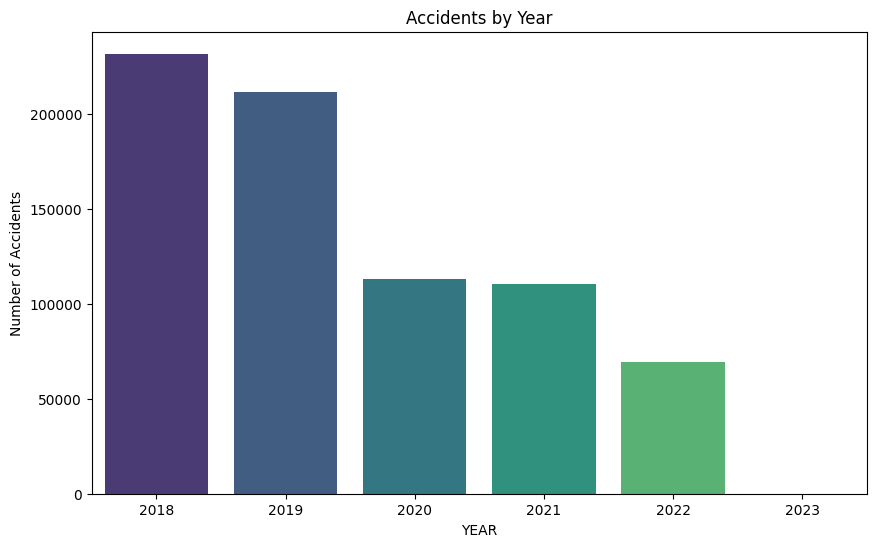

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Yearly trends
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='YEAR', palette="viridis")
plt.title('Accidents by Year')
plt.ylabel('Number of Accidents')
plt.show()


Monthly trends

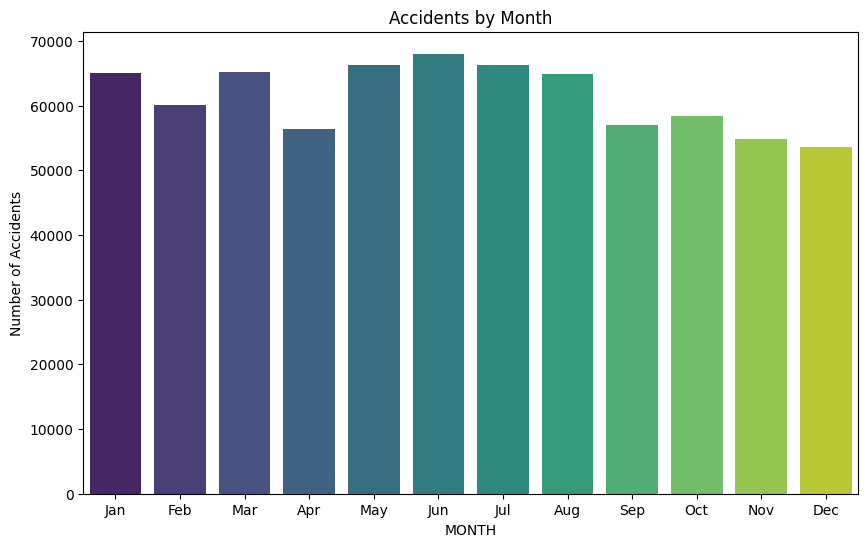

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MONTH', palette="viridis")
plt.title('Accidents by Month')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Hourly trends

In [60]:
df['HOUR'] = df['CRASH TIME'].apply(lambda x: x.hour)
print(df['HOUR'].value_counts().sort_index())


0     28361
1     13601
2     10385
3      9298
4     10172
5     11195
6     17706
7     24220
8     39094
9     36909
10    34931
11    37238
12    39839
13    41621
14    48446
15    47121
16    51208
17    50550
18    44487
19    36475
20    30398
21    26687
22    24673
23    21418
Name: HOUR, dtype: int64


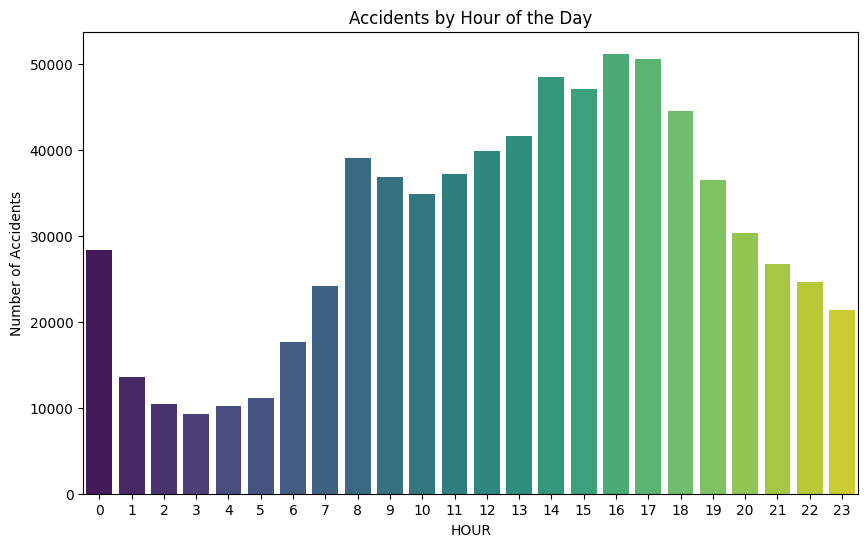

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='HOUR', palette="viridis")
plt.title('Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()


Day of week trend

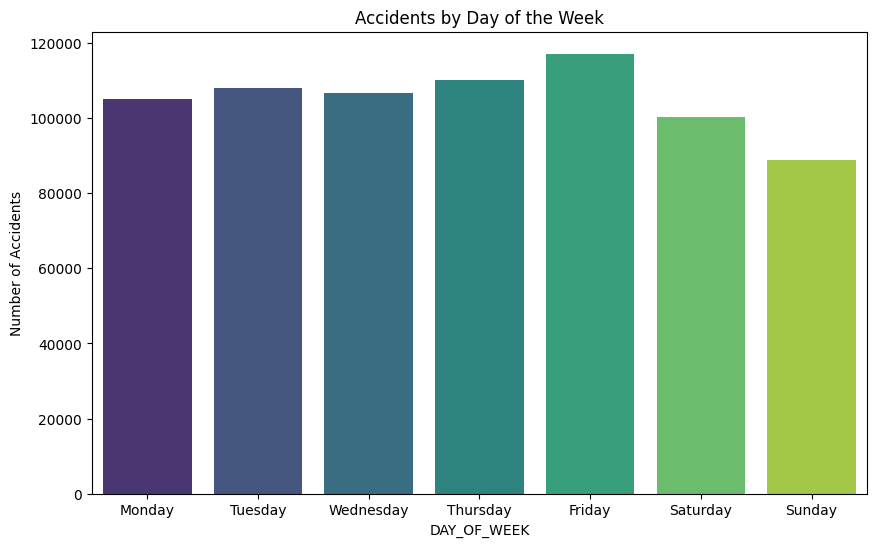

In [62]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAY_OF_WEEK', palette="viridis")
plt.title('Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


By time period

In [69]:
print(df.columns)


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'YEAR', 'CAUSE CATEGORY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR',
       'SEASON'],
      dtype='object')


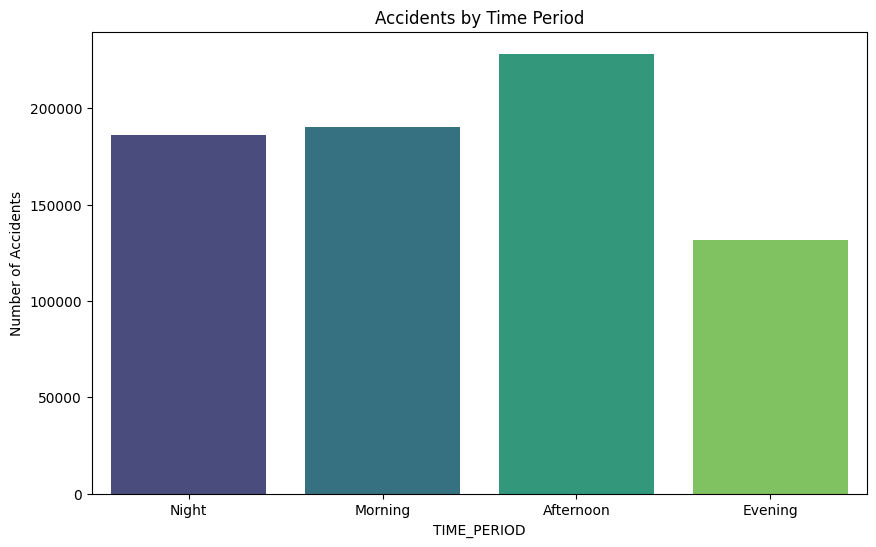

In [74]:
df['TIME_PERIOD'] = df['CRASH TIME'].apply(get_time_period)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='TIME_PERIOD', palette="viridis", order=['Night', 'Morning', 'Afternoon', 'Evening'])
plt.title('Accidents by Time Period')
plt.ylabel('Number of Accidents')
plt.show()


Seasons

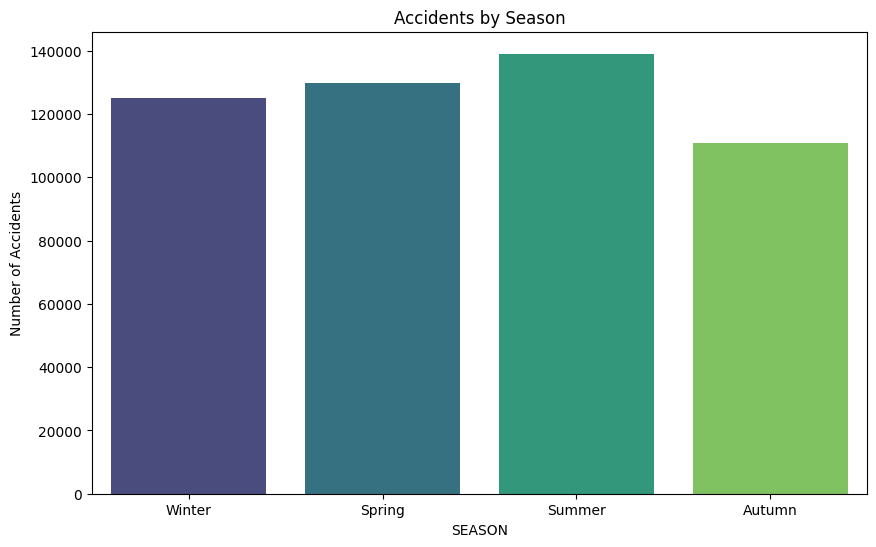

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='SEASON', palette="viridis", order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Accidents by Season')
plt.ylabel('Number of Accidents')
plt.show()


COMPARATIVE ANALYSIS

Accidents by borough and time

Yealy trend

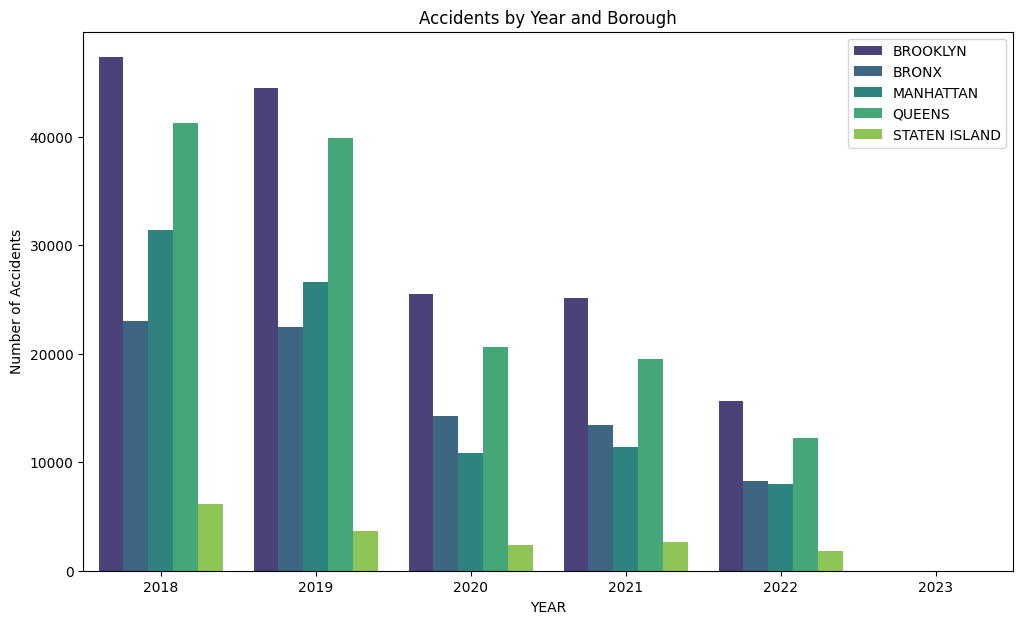

In [75]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='YEAR', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Year and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


Monthly trend (by borough)

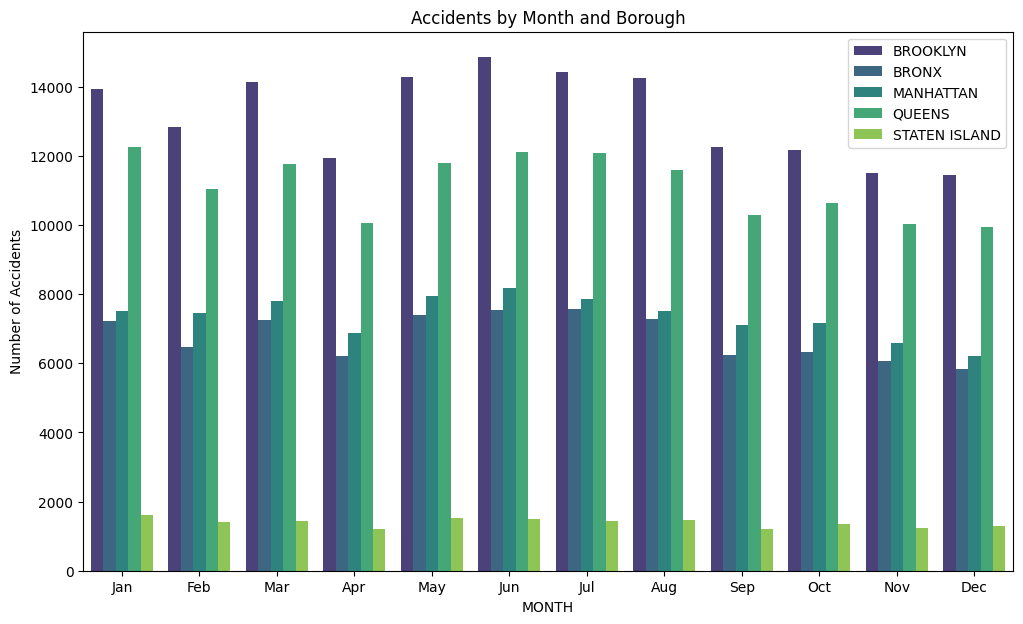

In [76]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='MONTH', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Month and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Hourly trend

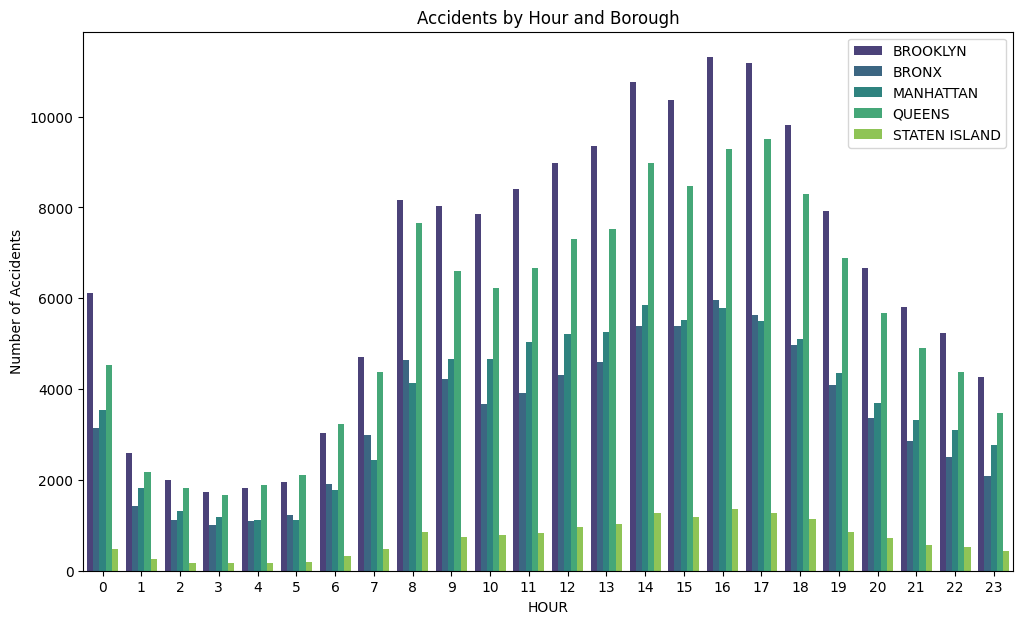

In [77]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='HOUR', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Hour and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


ACCIDENTS BY SEVERITY AND TIME

Yearly trend

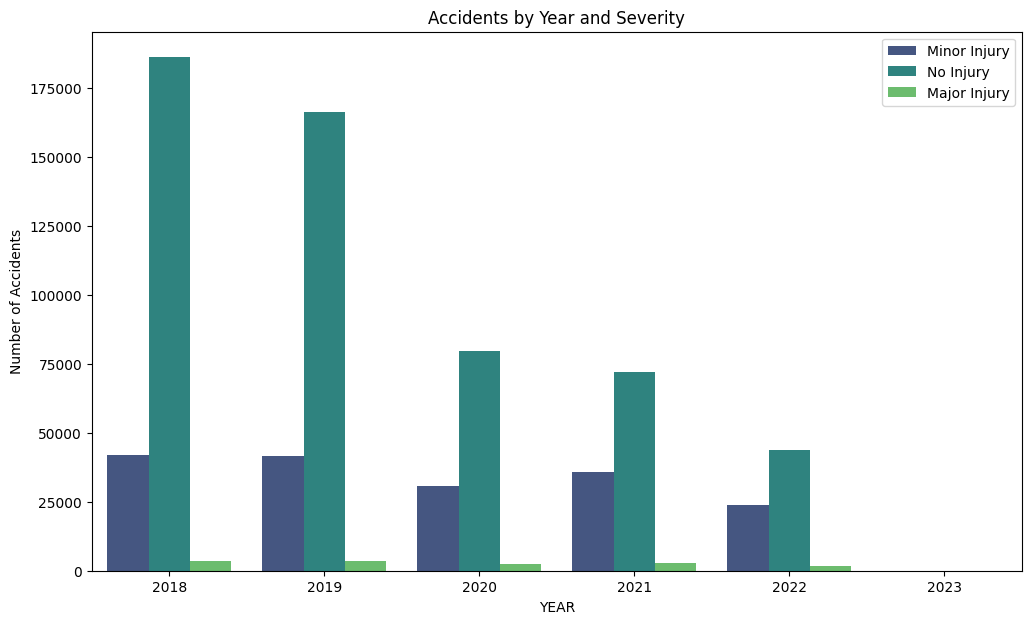

In [78]:
df['SEVERITY'] = df['NUMBER OF PERSONS INJURED'].apply(lambda x: 'No Injury' if x == 0 else ('Minor Injury' if x < 3 else 'Major Injury'))
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='YEAR', hue='SEVERITY', palette="viridis")
plt.title('Accidents by Year and Severity')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


Hourly by severity

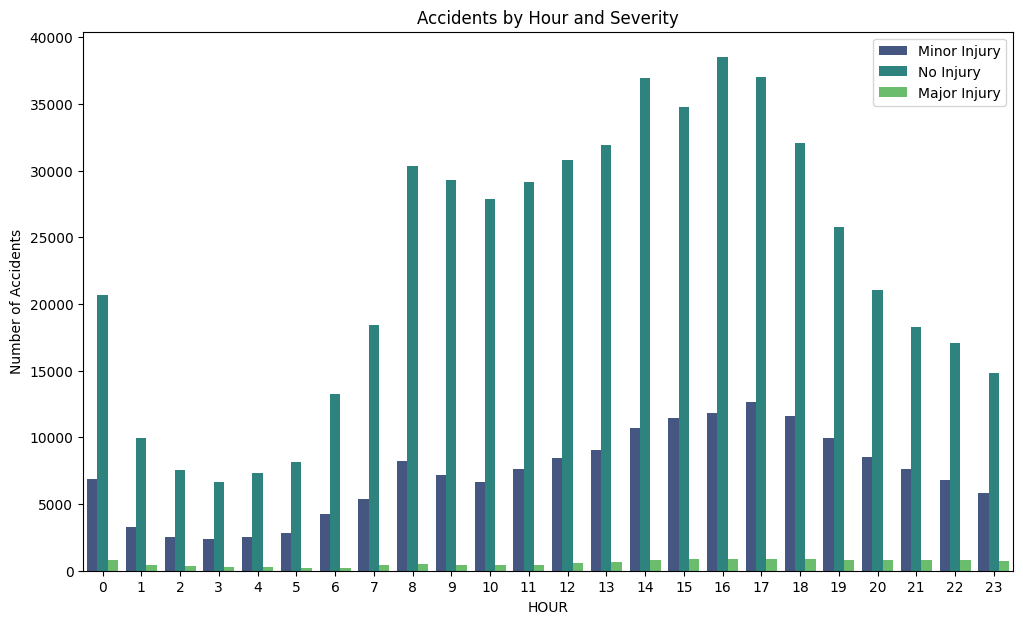

In [79]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='HOUR', hue='SEVERITY', palette="viridis")
plt.title('Accidents by Hour and Severity')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


ACCIDENTS BY CAUSES AND TIME

In [80]:
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']


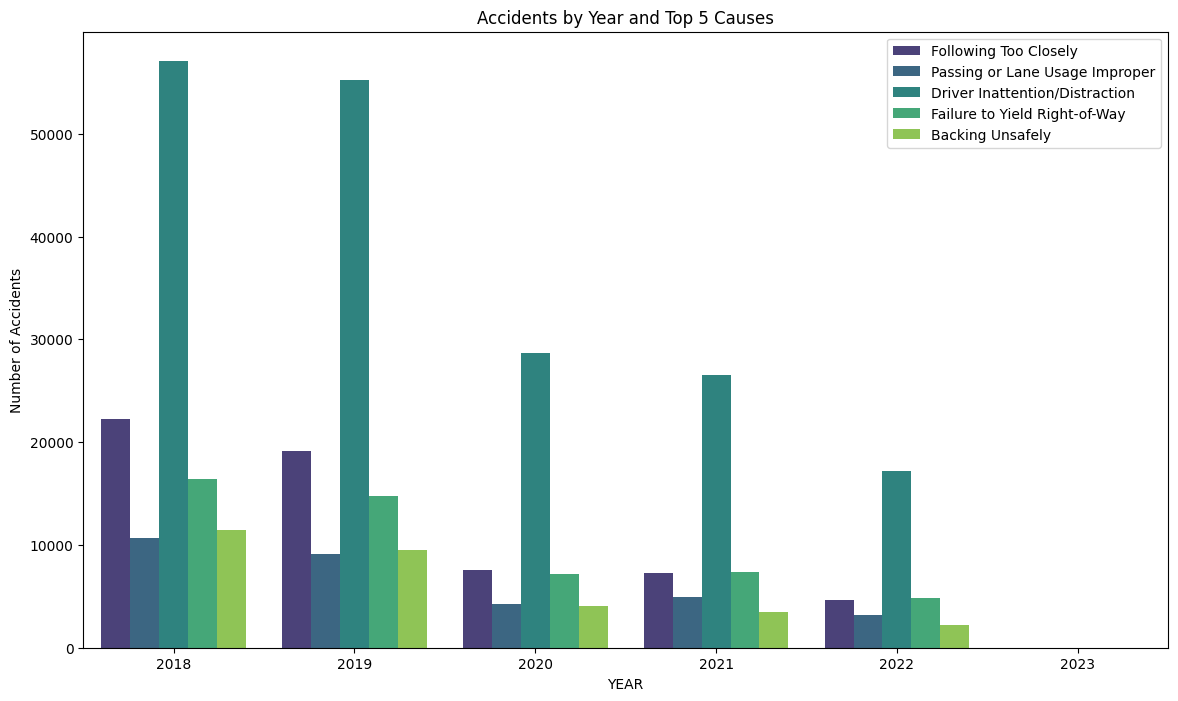

In [81]:
top_causes = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(5).index
filtered_df = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_causes)]
plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_df, x='YEAR', hue='CONTRIBUTING FACTOR VEHICLE 1', palette="viridis")
plt.title('Accidents by Year and Top 5 Causes')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


In [82]:
causation_mapping_df = pd.read_csv('/content/causation_factor_mapping_file.csv')


In [83]:
# Im "renaming" the columns their original name because my code wasn't registering their name.
causation_mapping_df.columns = ["Causation Factor", "Category"]

df = df.merge(causation_mapping_df, how='left', left_on='CONTRIBUTING FACTOR VEHICLE 1', right_on='Causation Factor')

df['Category'] = df['Category'].fillna('Unknown')

df.drop(columns=['Causation Factor'], inplace=True)


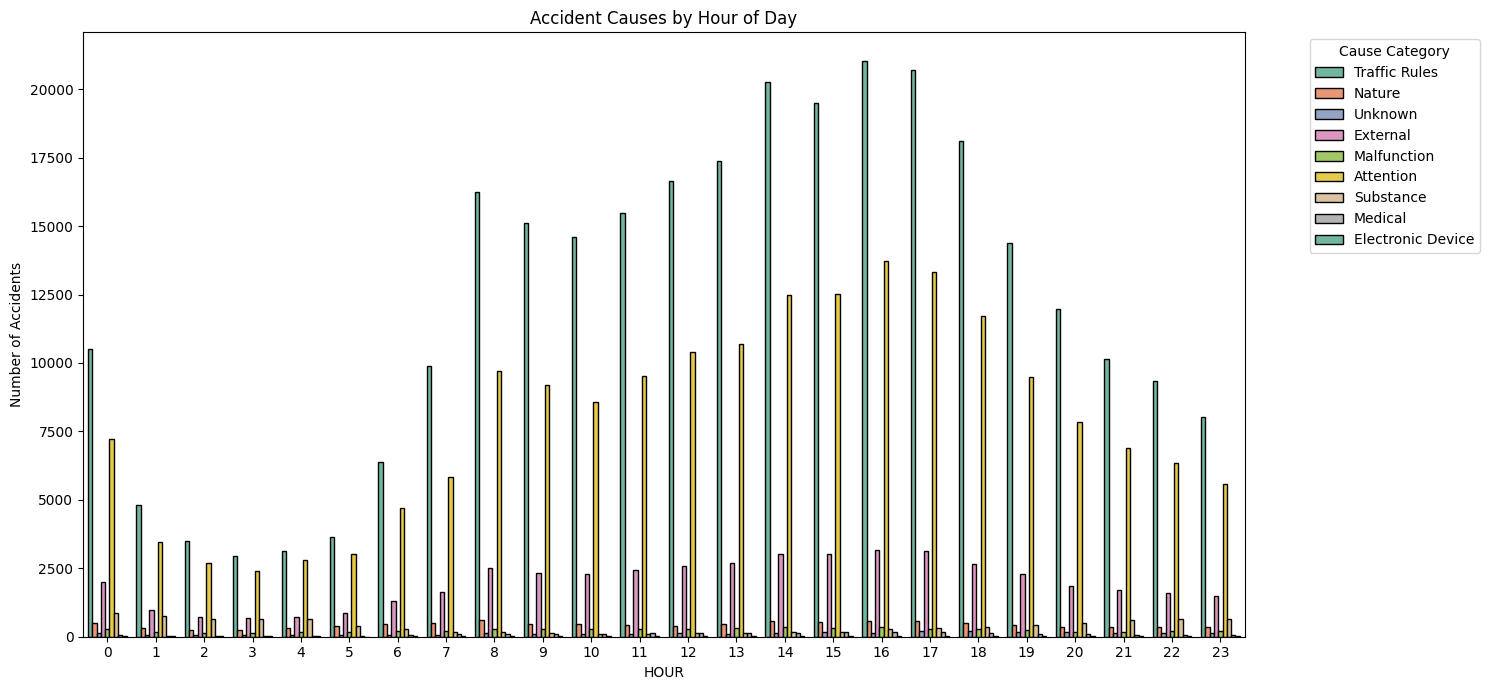

In [84]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='HOUR', hue='Category', palette="Set2", edgecolor='black')
plt.title('Accident Causes by Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


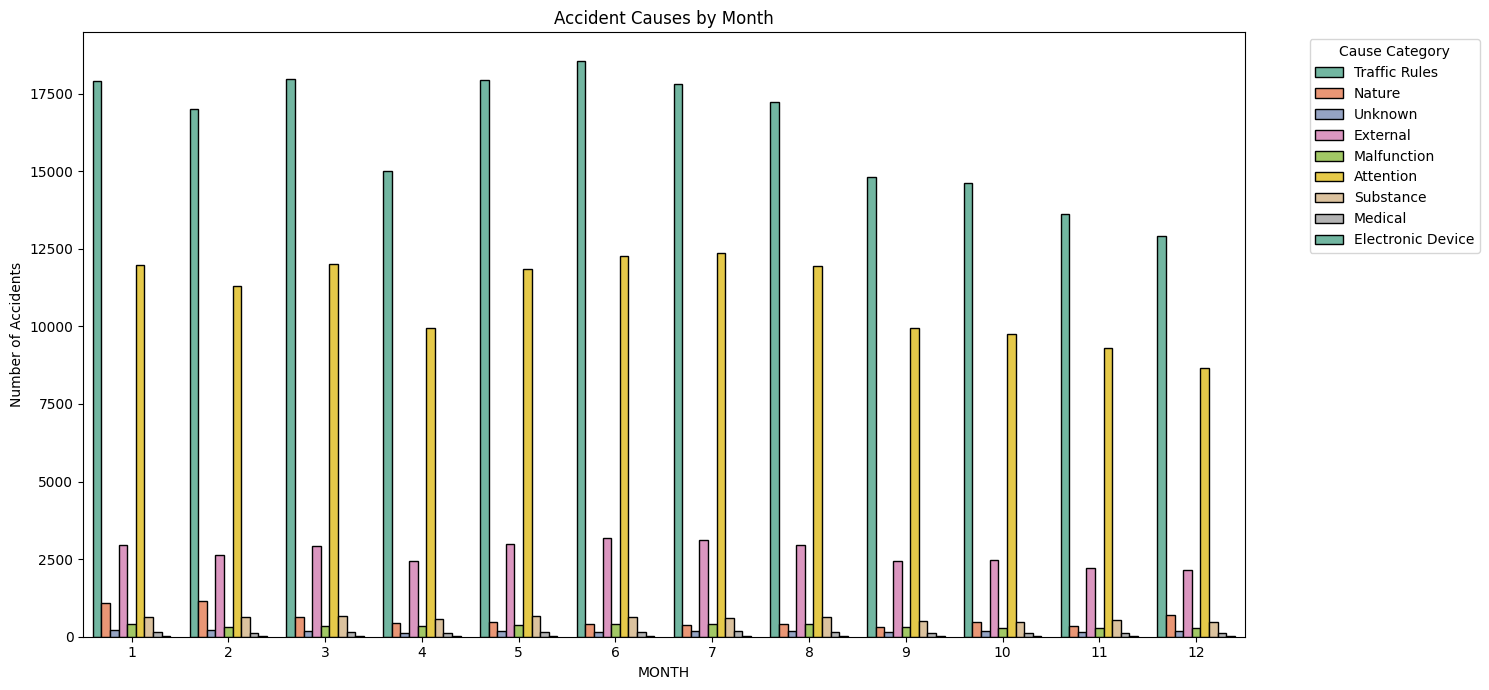

In [34]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='MONTH', hue='Category', palette="Set2", edgecolor='black')
plt.title('Accident Causes by Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Top 3 causes by hour and by month

In [85]:
# Identify top 3 causes across the whole dataset
top_3_causes = df['Category'].value_counts().index[:3]


By hour

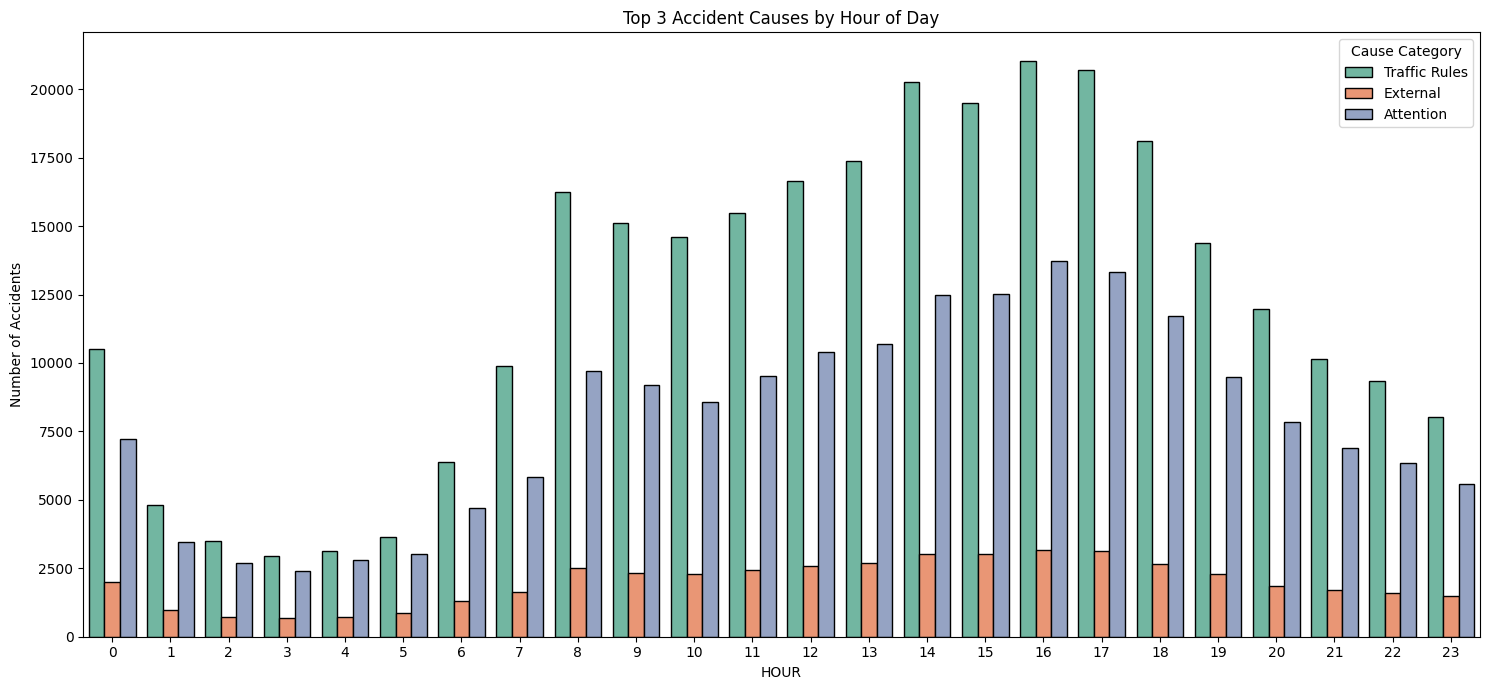

In [86]:
filtered_df_hour = df[df['Category'].isin(top_3_causes)]

plt.figure(figsize=(15,7))
sns.countplot(data=filtered_df_hour, x='HOUR', hue='Category', palette="Set2", edgecolor='black')
plt.title('Top 3 Accident Causes by Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category')
plt.tight_layout()
plt.show()


By month

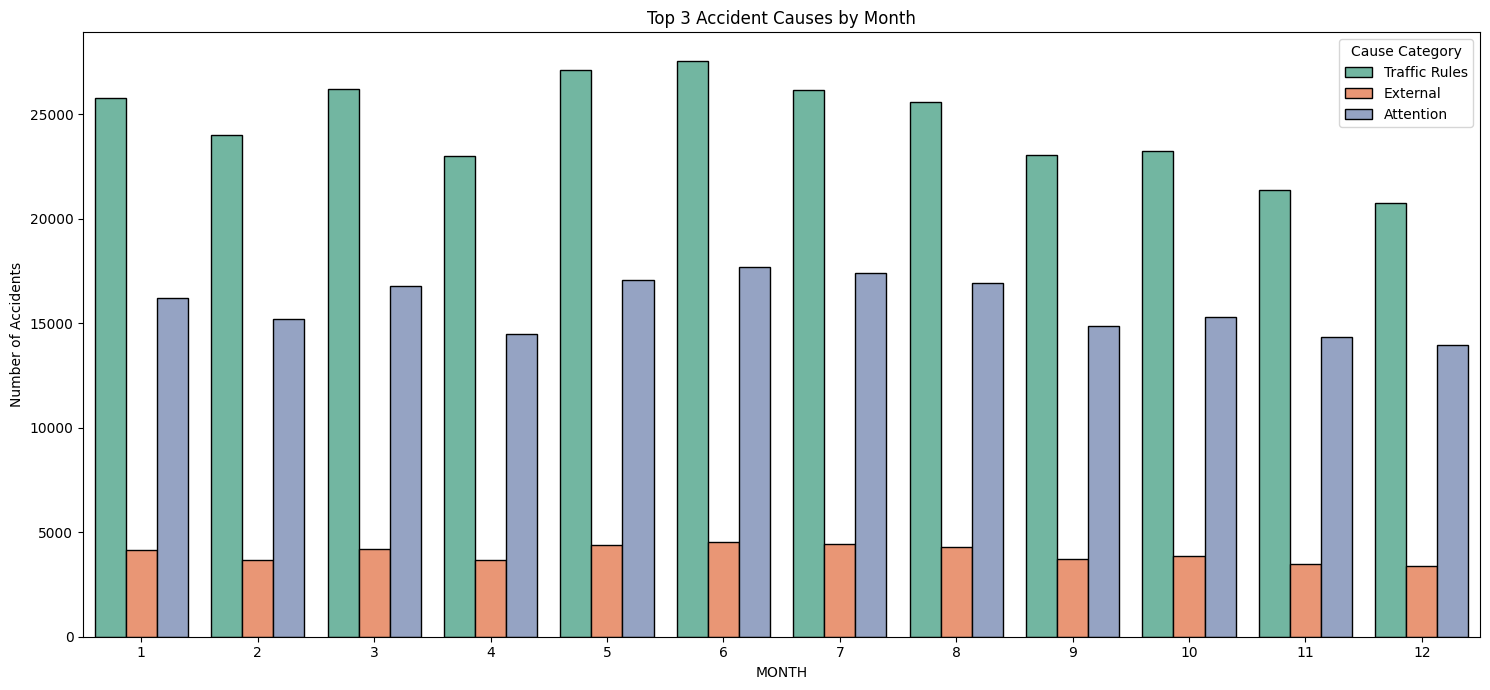

In [87]:
filtered_df_month = df[df['Category'].isin(top_3_causes)]

plt.figure(figsize=(15,7))
sns.countplot(data=filtered_df_month, x='MONTH', hue='Category', palette="Set2", edgecolor='black')
plt.title('Top 3 Accident Causes by Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category')
plt.tight_layout()
plt.show()


Causes of major injury accidents.

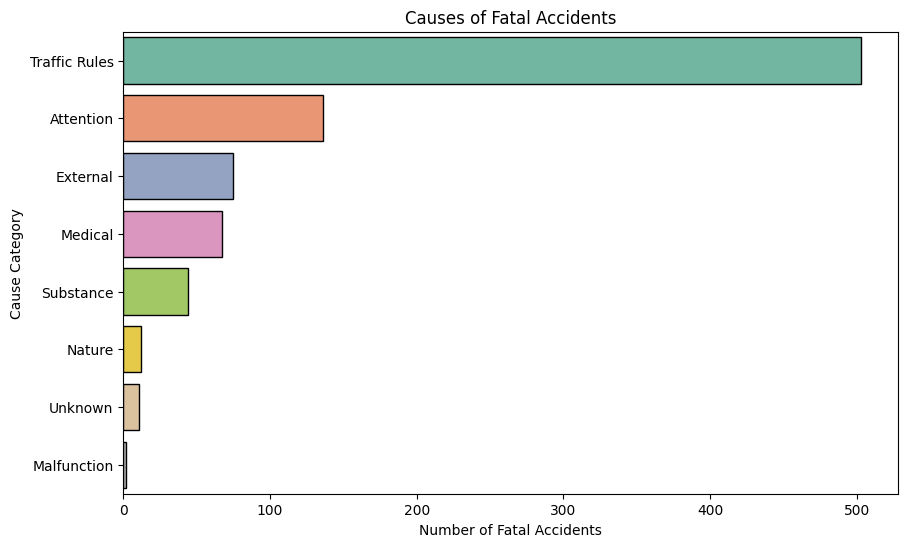

In [88]:
# Only include rows where there are fatalities
fatal_accidents_df = df[df['NUMBER OF PERSONS KILLED'] > 0]

plt.figure(figsize=(10, 6))
sns.countplot(data=fatal_accidents_df, y='Category', order=fatal_accidents_df['Category'].value_counts().index, palette="Set2", edgecolor='black')
plt.title('Causes of Fatal Accidents')
plt.xlabel('Number of Fatal Accidents')
plt.ylabel('Cause Category')
plt.show()


Let's look closer at fatalaties

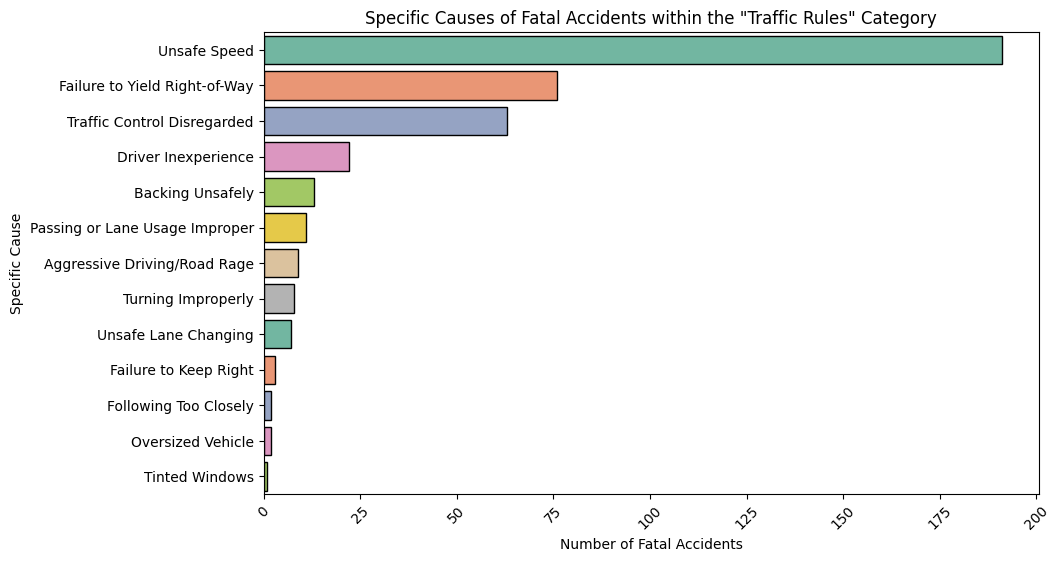

In [41]:
traffic_rules_fatal_df = fatal_accidents_df[fatal_accidents_df['Category'] == 'Traffic Rules']

plt.figure(figsize=(10, 6))
sns.countplot(data=traffic_rules_fatal_df, y='CONTRIBUTING FACTOR VEHICLE 1', order=traffic_rules_fatal_df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().index, palette="Set2", edgecolor='black')
plt.title('Specific Causes of Fatal Accidents within the "Traffic Rules" Category')
plt.xlabel('Number of Fatal Accidents')
plt.ylabel('Specific Cause')
plt.xticks(rotation=45)
plt.show()

In [104]:
fatalities_per_year_traffic_rules = traffic_rules_fatal_df.groupby('YEAR')['NUMBER OF PERSONS KILLED'].sum()

print(fatalities_per_year_traffic_rules)

YEAR
2019     94.0
2020    134.0
2021    127.0
2022     87.0
Name: NUMBER OF PERSONS KILLED, dtype: float64


At this point im trying to understand fatalaties a bit more. Let's look at unsafe speed fatalaties by season.

In [114]:
import pandas as pd

df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv')



<ipython-input-114-989f6582bef7>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv')


In [117]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428449 entries, 0 to 1428448
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     1428449 non-null  object 
 1   CRASH TIME                     1428449 non-null  object 
 2   BOROUGH                        948299 non-null   object 
 3   ZIP CODE                       948066 non-null   object 
 4   LATITUDE                       1283749 non-null  float64
 5   LONGITUDE                      1283749 non-null  float64
 6   LOCATION                       1283749 non-null  object 
 7   ON STREET NAME                 1100964 non-null  object 
 8   CROSS STREET NAME              793545 non-null   object 
 9   OFF STREET NAME                292618 non-null   object 
 10  NUMBER OF PERSONS INJURED      1428431 non-null  float64
 11  NUMBER OF PERSONS KILLED       1428418 non-null  float64
 12  NUMBER OF PEDE

In [118]:
import pandas as pd

with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()
    for i in range(656688, 656694):  # Checking a few lines around the problematic row
        print(i, lines[i-1])  # Adjusting for 0-indexing

656688 04/25/2018,8:39,,,40.63529,-73.958206,"(40.63529, -73.958206)",OCEAN AVENUE                    ,,,1,0,0,0,0,0,1,0,Driver Inattention/Distraction,Unspecified,,,,3887903,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,,,

656689 05/08/2018,16:13,,,40.61384,-73.981445,"(40.61384, -73.981445)",65 STREET                       ,,,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,,,,3896211,Box Truck,Station Wagon/Sport Utility Vehicle,,,

656690 04/29/2018,14:45,BROOKLYN,11208,40.668613,-73.86857,"(40.668613, -73.86857)",,,2602      LINDEN BOULEVARD              ,0,0,0,0,0,0,0,0,Unspecified,,,,,3891070,Station Wagon/Sport Utility Vehicle,,,,

656691 05/14/2018,15:00,,,40.617573,-74.15293,"(40.617573, -74.15293)",,,5         DEPPE PLACE                   ,0,0,0,0,0,0,0,0,Following Too Closely,Following Too Closely,Unspecified,,,3900833,Sedan,Station Wagon/Sport Utility Vehicle,,,

656692 05/06/2018,11:30,BRONX,10458,40.856358,-73.88591,"(40.856358, -73.

In [119]:
df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv', skiprows=[656692])


<ipython-input-119-1227a6f6c89a>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv', skiprows=[656692])


In [120]:
with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()

# Excluding problematic line
cleaned_lines = [line for idx, line in enumerate(lines) if idx != 656691]

# Converting cleaned lines into a df
from io import StringIO
data = StringIO('\n'.join(cleaned_lines))
df = pd.read_csv(data)

<ipython-input-120-b48ccfd3e3cc>:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data)


In [121]:
df['YEAR'] = df['CRASH DATE'].apply(lambda x: int(x.split('/')[2]))
df = df[df['YEAR'] > 2017]


In [124]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME']).dt.time

In [125]:
# Extracting Month, Day, Day of the Week, and Hour
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['DAY_OF_WEEK'] = df['CRASH DATE'].dt.dayofweek  # Returns 0 for Monday and 6 for Sunday
df['HOUR'] = df['CRASH DATE'].dt.hour


In [126]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['SEASON'] = df['MONTH'].apply(get_season)

In [128]:
from datetime import time

def get_time_period(t):
    if t < time(6, 0):
        return 'Night'
    elif t < time(12, 0):
        return 'Morning'
    elif t < time(17, 0):
        return 'Afternoon'
    elif t < time(20, 0):
        return 'Evening'
    else:
        return 'Night'

df['TIME_PERIOD'] = df['CRASH TIME'].apply(get_time_period)

In [129]:
print(df[['MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR', 'SEASON', 'TIME_PERIOD']].head())

   MONTH  DAY  DAY_OF_WEEK  HOUR  SEASON TIME_PERIOD
0      9   11            5     0  Autumn       Night
1      3   26            5     0  Spring     Morning
2      6   29            2     0  Summer     Morning
3      9   11            5     0  Autumn     Morning
4     12   14            1     0  Winter     Morning


In [131]:
# Filtering df for the year 2019, fatalities and usafe Speed
fatalities_2019_unsafe_speed_df = df[
    (df['YEAR'] == 2019) &
    (df['NUMBER OF PERSONS KILLED'] > 0) &
    (df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed')
]

seasonal_fatalities_2019_unsafe_speed = fatalities_2019_unsafe_speed_df.groupby('SEASON').size()

print(seasonal_fatalities_2019_unsafe_speed)



SEASON
Autumn     8
Spring     7
Summer    13
Winter     7
dtype: int64


I want to know if their is statistical significance bvetween the value of the respective seasons. Start with Chi-test (good for categorical)

In [132]:
import scipy.stats as stats

# Creating a contingency table
contingency_table = pd.crosstab(fatalities_2019_unsafe_speed_df['SEASON'], columns="count")

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"P-value: {p}")



P-value: 1.0


Non-parametric alternative Kruskal test

In [133]:
from scipy.stats import kruskal

# Getting fatality counts for each season
spring = fatalities_2019_unsafe_speed_df[fatalities_2019_unsafe_speed_df['SEASON'] == 'Spring']['NUMBER OF PERSONS KILLED']
summer = fatalities_2019_unsafe_speed_df[fatalities_2019_unsafe_speed_df['SEASON'] == 'Summer']['NUMBER OF PERSONS KILLED']
fall = fatalities_2019_unsafe_speed_df[fatalities_2019_unsafe_speed_df['SEASON'] == 'Fall']['NUMBER OF PERSONS KILLED']
winter = fatalities_2019_unsafe_speed_df[fatalities_2019_unsafe_speed_df['SEASON'] == 'Winter']['NUMBER OF PERSONS KILLED']

h_stat, p_val = kruskal(spring, summer, fall, winter, nan_policy='omit')

print(f"P-value: {p_val}")


P-value: nan


I believe the sample size is too small. I wanted to hone in on one year to get a more micro view of the problem seasons, but for these tests that may not be wise. Let's zoom out. Focus on all years (2018-2023)

In [138]:
unsafe_speed_fatalities_df = df[
    (df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed') &
    (df['NUMBER OF PERSONS KILLED'] > 0)
]

seasonal_unsafe_speed_fatalities = unsafe_speed_fatalities_df.groupby('SEASON').size()

print(seasonal_unsafe_speed_fatalities)



SEASON
Autumn    53
Spring    45
Summer    82
Winter    37
dtype: int64


In [ ]:
causation_mapping_df = pd.read_csv('causation_factor_mapping_file.csv')

def map_causation(cause, mapping_df):
    """Return the category corresponding to a causation factor."""

    if pd.isna(cause):
        return 'Unknown'

    return mapping_df[mapping_df['Causation Factor'] == cause]['Category'].iloc[0]

# Apply the mapping function to the 'CONTRIBUTING FACTOR VEHICLE 1' column
df['CAUSE CATEGORY'] = df['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: map_causation(x, causation_mapping_df))


In [139]:
total_fatalities_unsafe_speed = df[
    (df['CAUSE CATEGORY'] == 'Traffic Rules') &
    (df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed')
]['NUMBER OF PERSONS KILLED'].sum()

print(f"Total number of fatalities caused by Unsafe Speed from 2018-2023: {total_fatalities_unsafe_speed}")


KeyError: ignored